In [2]:
import numpy as np
import matplotlib as plt
import math
from graphviz import Digraph

In [42]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda : None

    def __repr__(self):
        return f"Value(data={self.data})"
  
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(data=t,_children=(self,),_op='tanh')
        def _backward():
            self.grad += (1 - out.data ** 2) * out.grad 
        out._backward = _backward
        return out
    def backward(self):
        sorted_nodes = []
        visited = set()
        def topological_sort(n):
            if n not in visited:
                visited.add(n)
                for child in n._prev:
                    topological_sort(child)
                sorted_nodes.append(n)
        self.grad = 1
        topological_sort(self)
        for n in reversed(sorted_nodes):
            n._backward()

    

In [4]:
a = Value(3)
a

Value(data=3)

In [5]:
b = Value(2)

In [6]:
a+b

Value(data=5)

In [7]:
d = a*b
d.label ='d'
a.label= 'a'
b.label = 'b'

In [8]:
c=Value(2)
a*b+c

Value(data=8)

In [9]:
d._prev,d._op

({Value(data=2), Value(data=3)}, '*')

In [10]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [11]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [38]:
def build_graph(root):
    nodes,edges = set(),set()
    def build(root):
        if root not in nodes:
            nodes.add(root)
            for child in root._prev:
                edges.add((child,root))
                build(child)
    build(root)
    return nodes,edges

def draw_graph(root):
    graph = Digraph(format='svg',graph_attr={'rankdir':'LR'})
    nodes,edges = build_graph(root)
    for n in nodes:
        uid = str(id(n))
        graph.node(name=uid,label="%s | data %.4f | grad %.4f"%(n.label,n.data,n.grad),shape='record')
        if n._op:
            opid = uid + n._op
            graph.node(name=opid,label=n._op)
            graph.edge(opid,uid)
    for n1,n2 in edges:
        graph.edge(str(id(n1)),str(id(n2))+n2._op)
    return graph

In [14]:
a = Value(2);a.label = 'a'
b = Value(4);b.label = 'b'
x = a + b;x.label='x'
y = Value(7);y.label = 'y'
z = x+y;z.label='z'
build_graph(z)

({Value(data=13), Value(data=2), Value(data=4), Value(data=6), Value(data=7)},
 {(Value(data=2), Value(data=6)),
  (Value(data=4), Value(data=6)),
  (Value(data=6), Value(data=13)),
  (Value(data=7), Value(data=13))})

In [44]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

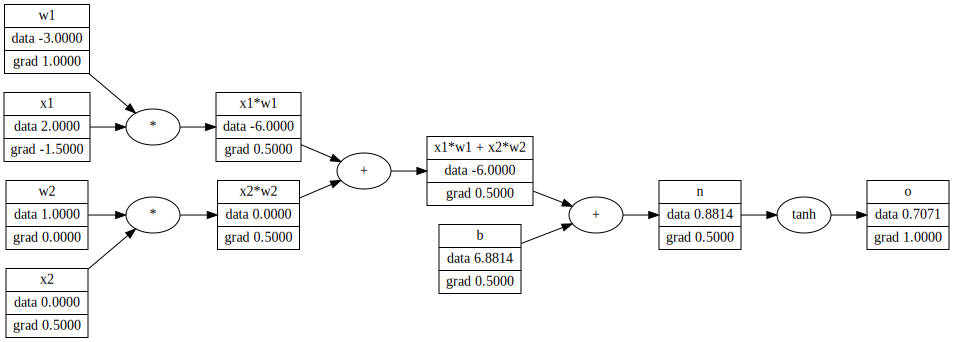

In [47]:
draw_graph(o)

In [46]:
o.backward()